In [1]:
import numpy as np

chrom, inter_start_pos, inter_end_pos = '22', 24332998, 24406719

#chrom, inter_start_pos, inter_end_pos = '1', 25550000, 25680000

#chrom, inter_start_pos, inter_end_pos = '5', 168166000, 168172000

phase_dir = '../phased_ihart'
family_sizes = [3, 4, 5, 6, 7]

ssc_phase_dir = '../phased_ssc'
ssc_family_sizes = [4]

In [2]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [3]:
ihart_family_to_individuals = dict()

for j in family_sizes:
    try:
        with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header
            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                ihart_family_to_individuals[family_key] = pieces[1:(1+j)]
    except:
        pass

ihart_individuals = sorted(sum(ihart_family_to_individuals.values(), []))
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])
                            

In [4]:
ssc_family_to_individuals = dict()

for j in ssc_family_sizes:
    try:
        with open('%s/chr.%s.familysize.%d.families.txt' % (ssc_phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header
            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                ssc_family_to_individuals[family_key] = pieces[1:(1+j)]
    except:
        pass

ssc_individuals = sorted(sum(ssc_family_to_individuals.values(), []))
ssc_ind_to_index = dict([(x, i) for i, x in enumerate(ssc_individuals)])
                            

In [5]:
print('ihart families', len(ihart_family_to_individuals))
print('ssc families', len(ssc_family_to_individuals))

ihart families 880
ssc families 518


In [6]:
from collections import defaultdict

# -1: unknown
# 0: no deletions (homref)
# 1: het deletion
# 2: homalt deletion
# 3: either 0 or 1
# 4: either 1 or 2

ihart_deletions = -np.ones((len(ihart_individuals), inter_end_pos-inter_start_pos+1), dtype=np.int8)
gen_to_code = {(-1, -1): -1,
               (-1, 0): 4,
               (-1, 1): 3,
               (0, -1): 4,
               (0, 0): 2,
               (0, 1): 1,
               (1, -1): 3,
               (1, 0): 1,
               (1, 1): 0
              }

for j in family_sizes:
    try:
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in ihart_family_to_individuals:
                    inds = ihart_family_to_individuals[family_key]
                    indices = [ihart_ind_to_index[x] for x in inds]
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]

                    if start_pos <= inter_start_pos and inter_end_pos <= end_pos:
                        start_pos, end_pos = inter_start_pos, inter_end_pos
                    elif inter_start_pos <= start_pos and end_pos <= inter_end_pos:
                        pass
                    elif inter_start_pos <= start_pos and start_pos <= inter_end_pos:
                        end_pos = min(end_pos, inter_end_pos)
                    elif inter_start_pos <= end_pos and end_pos <= inter_end_pos:
                        start_pos = max(start_pos, inter_start_pos)
                    else:
                        start_pos, end_pos = None, None

                    if start_pos is not None and state[-1]==0:
                        # mom
                        if state[0] == 0 and state[1] == 0:
                            pass
                        else:
                            if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                                state[0] = -1
                            if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                                state[1] = -1
                        ihart_deletions[indices[0], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[0], state[1])]

                        # dad
                        if state[2] == 0 and state[3] == 0:
                            pass
                        else:
                            if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                                state[2] = -1
                            if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                                state[3] = -1
                        ihart_deletions[indices[1], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[2], state[3])]

                        # children
                        for i in range(2, j):
                            mom_s, dad_s = state[(2*i):(2*(i+1))]
                            if mom_s == -1:
                                mom_gen = -1
                            else:
                                mom_gen = state[mom_s]
                            if dad_s == -1:
                                dad_gen = -1
                            else:
                                dad_gen = state[2+dad_s]
                            ihart_deletions[indices[i], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(mom_gen, dad_gen)]
    except:
        pass
                
                

In [7]:
from collections import defaultdict

# -1: unknown
# 0: no deletions (homref)
# 1: het deletion
# 2: homalt deletion
# 3: either 0 or 1
# 4: either 1 or 2

ssc_deletions = -np.ones((len(ssc_individuals), inter_end_pos-inter_start_pos+1), dtype=np.int8)

for j in ssc_family_sizes:
    try:
        with open('%s/chr.%s.familysize.%d.phased.txt' % (ssc_phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in ssc_family_to_individuals:
                    inds = ssc_family_to_individuals[family_key]
                    indices = [ssc_ind_to_index[x] for x in inds]
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]

                    if start_pos <= inter_start_pos and inter_end_pos <= end_pos:
                        start_pos, end_pos = inter_start_pos, inter_end_pos
                    elif inter_start_pos <= start_pos and end_pos <= inter_end_pos:
                        pass
                    elif inter_start_pos <= start_pos and start_pos <= inter_end_pos:
                        end_pos = min(end_pos, inter_end_pos)
                    elif inter_start_pos <= end_pos and end_pos <= inter_end_pos:
                        start_pos = max(start_pos, inter_start_pos)
                    else:
                        start_pos, end_pos = None, None

                    if start_pos is not None:
                        # mom
                        if state[0] == 0 and state[1] == 0:
                            pass
                        else:
                            if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                                state[0] = -1
                            if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                                state[1] = -1
                        ssc_deletions[indices[0], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[0], state[1])]

                        # dad
                        if state[2] == 0 and state[3] == 0:
                            pass
                        else:
                            if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                                state[2] = -1
                            if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                                state[3] = -1
                        ssc_deletions[indices[1], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[2], state[3])]

                        # children
                        for i in range(2, j):
                            momgen, dadgen = state[(2*i):(2*(i+1))]
                            ssc_deletions[indices[i], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[momgen], state[2+dadgen])]
    except:
        pass
                
                

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.imshow(ihart_deletions, aspect='auto')
plt.colorbar()
plt.show()

//anaconda/lib/python3.6/site-packages/matplotlib/transforms.py:2950: RuntimeWarning: overflow encountered in byte_scalars
  elif vmax - vmin <= maxabsvalue * tiny:


<Figure size 1500x500 with 2 Axes>

In [9]:
print(ihart_deletions.shape)
print(ssc_deletions.shape)

(3994, 73722)
(2072, 73722)


In [10]:
ihart_is_child = np.zeros((len(ihart_individuals),), dtype=bool)
ihart_is_mother = np.zeros((len(ihart_individuals),), dtype=bool)
ihart_is_father = np.zeros((len(ihart_individuals),), dtype=bool)
for inds in ihart_family_to_individuals.values():
    ihart_is_mother[ihart_ind_to_index[inds[0]]] = True
    ihart_is_father[ihart_ind_to_index[inds[1]]] = True
    for child in inds[2:]:
        ihart_is_child[ihart_ind_to_index[child]] = True
        
        

In [11]:
ssc_is_child = np.zeros((len(ssc_individuals),), dtype=bool)
ssc_is_mother = np.zeros((len(ssc_individuals),), dtype=bool)
ssc_is_father = np.zeros((len(ssc_individuals),), dtype=bool)
for inds in ssc_family_to_individuals.values():
    ssc_is_mother[ssc_ind_to_index[inds[0]]] = True
    ssc_is_father[ssc_ind_to_index[inds[1]]] = True
    for child in inds[2:]:
        ssc_is_child[ssc_ind_to_index[child]] = True
        

All
1835 399
518 518
Males
1419 193
463 230
Females
416 206
55 288


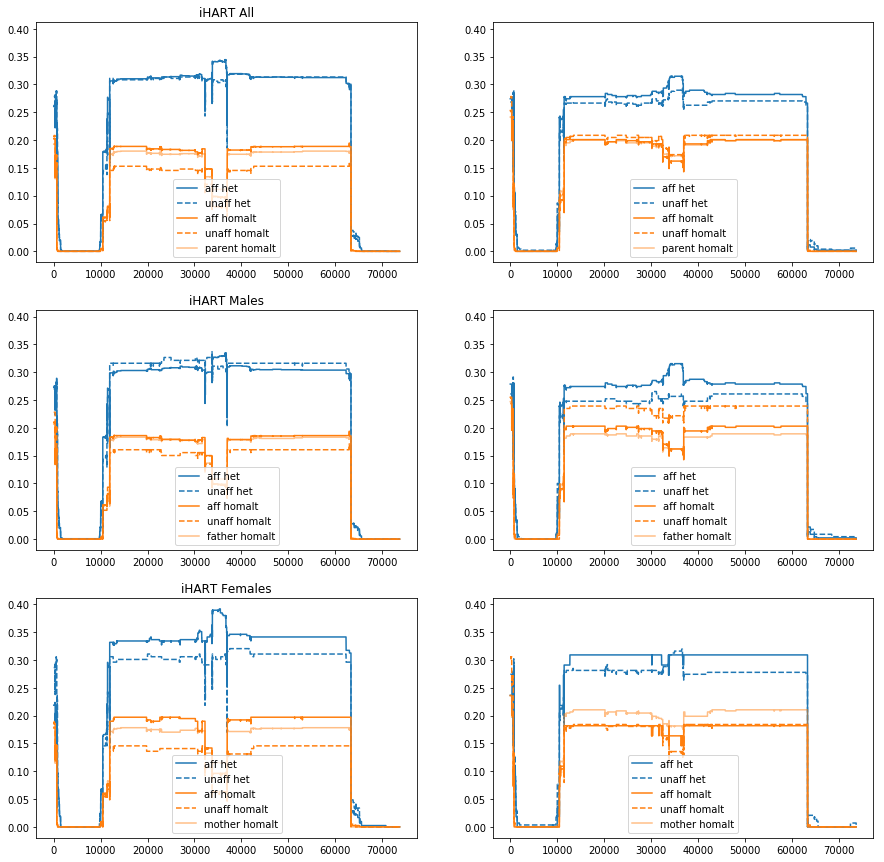

In [12]:
plt.figure(figsize=(15, 15))

ax = plt.subplot(3, 2, 1)
plt.title('iHART All')
ihart_affected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '2' and ihart_is_child[i]]
ihart_unaffected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '1' and ihart_is_child[i]]
ssc_affected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '2' and ssc_is_child[i]]
ssc_unaffected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '1' and ssc_is_child[i]]
print('All')
print(len(ihart_affected_indices), len(ihart_unaffected_indices))
print(len(ssc_affected_indices), len(ssc_unaffected_indices))

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==1, axis=0)/len(ihart_affected_indices), label='aff het')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==1, axis=0)/len(ihart_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ihart_deletions[~ihart_is_child, :]==1, axis=0)/np.sum(~ihart_is_child), label='parent het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==2, axis=0)/len(ihart_affected_indices), label='aff homalt')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==2, axis=0)/len(ihart_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ihart_deletions[~ihart_is_child, :]==2, axis=0)/np.sum(~ihart_is_child), label='parent homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 2, sharey=ax)
p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==1, axis=0)/len(ssc_affected_indices), label='aff het')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==1, axis=0)/len(ssc_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ssc_deletions[~ssc_is_child, :]==1, axis=0)/np.sum(~ssc_is_child), label='parent het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==2, axis=0)/len(ssc_affected_indices), label='aff homalt')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==2, axis=0)/len(ssc_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ssc_deletions[~ssc_is_child, :]==2, axis=0)/np.sum(~ssc_is_child), label='parent homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 3, sharey=ax)
plt.title('iHART Males')
ihart_affected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and ihart_is_child[i]]
ihart_unaffected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '1' and ihart_is_child[i]]
ssc_affected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and ssc_is_child[i]]
ssc_unaffected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '1' and ssc_is_child[i]]
print('Males')
print(len(ihart_affected_indices), len(ihart_unaffected_indices))
print(len(ssc_affected_indices), len(ssc_unaffected_indices))

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==1, axis=0)/len(ihart_affected_indices), label='aff het')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==1, axis=0)/len(ihart_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ihart_deletions[ihart_is_father, :]==1, axis=0)/np.sum(ihart_is_father), label='father het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==2, axis=0)/len(ihart_affected_indices), label='aff homalt')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==2, axis=0)/len(ihart_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ihart_deletions[ihart_is_father, :]==2, axis=0)/np.sum(ihart_is_father), label='father homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 4, sharey=ax)
p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==1, axis=0)/len(ssc_affected_indices), label='aff het')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==1, axis=0)/len(ssc_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ssc_deletions[ssc_is_father, :]==1, axis=0)/np.sum(ssc_is_father), label='father het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==2, axis=0)/len(ssc_affected_indices), label='aff homalt')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==2, axis=0)/len(ssc_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ssc_deletions[ssc_is_father, :]==2, axis=0)/np.sum(ssc_is_father), label='father homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 5, sharey=ax)
plt.title('iHART Females')
ihart_affected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '2' and ihart_is_child[i]]
ihart_unaffected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '2' and ihart_is_child[i]]
ssc_affected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '2' and ssc_is_child[i]]
ssc_unaffected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '2' and ssc_is_child[i]]
print('Females')
print(len(ihart_affected_indices), len(ihart_unaffected_indices))
print(len(ssc_affected_indices), len(ssc_unaffected_indices))

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==1, axis=0)/len(ihart_affected_indices), label='aff het')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==1, axis=0)/len(ihart_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ihart_deletions[ihart_is_mother, :]==1, axis=0)/np.sum(ihart_is_mother), label='mother het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==2, axis=0)/len(ihart_affected_indices), label='aff homalt')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==2, axis=0)/len(ihart_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ihart_deletions[ihart_is_mother, :]==2, axis=0)/np.sum(ihart_is_mother), label='mother homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 6, sharey=ax)
p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==1, axis=0)/len(ssc_affected_indices), label='aff het')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==1, axis=0)/len(ssc_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ssc_deletions[ssc_is_mother, :]==1, axis=0)/np.sum(ssc_is_mother), label='mother het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==2, axis=0)/len(ssc_affected_indices), label='aff homalt')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==2, axis=0)/len(ssc_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ssc_deletions[ssc_is_mother, :]==2, axis=0)/np.sum(ssc_is_mother), label='mother homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.show()

In [13]:
ihart_contingency = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)
ihart_contingency_f = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)
ihart_contingency_m = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)

for inds in ihart_family_to_individuals.values():
    indices = [ihart_ind_to_index[x] for x in inds]
    mom_index, dad_index = indices[:2]
    for child_index, child in zip(indices[2:], inds[2:]):
        a = ((ihart_deletions[mom_index, :]==0) & (ihart_deletions[dad_index, :]==1) & (ihart_deletions[child_index, :]==1)) \
            + ((ihart_deletions[mom_index, :]==1) & (ihart_deletions[dad_index, :]==0) & (ihart_deletions[child_index, :]==1)) \
            + ((ihart_deletions[mom_index, :]==2) & (ihart_deletions[dad_index, :]==1) & (ihart_deletions[child_index, :]==2)) \
            + ((ihart_deletions[mom_index, :]==1) & (ihart_deletions[dad_index, :]==2) & (ihart_deletions[child_index, :]==2))
        
        b = ((ihart_deletions[mom_index, :]==0) & (ihart_deletions[dad_index, :]==1) & (ihart_deletions[child_index, :]==0)) \
            + ((ihart_deletions[mom_index, :]==1) & (ihart_deletions[dad_index, :]==0) & (ihart_deletions[child_index, :]==0)) \
            + ((ihart_deletions[mom_index, :]==2) & (ihart_deletions[dad_index, :]==1) & (ihart_deletions[child_index, :]==1)) \
            + ((ihart_deletions[mom_index, :]==1) & (ihart_deletions[dad_index, :]==2) & (ihart_deletions[child_index, :]==1)) 
        
        aff = int(child_id_to_affected[child] == '2')
        ihart_contingency[:, aff, 1] += a
        ihart_contingency[:, aff, 0] += b
                     
        if child_id_to_sex[child] == '2':
            ihart_contingency_f[:, aff, 1] += a
            ihart_contingency_f[:, aff, 0] += b
        else:
            ihart_contingency_m[:, aff, 1] += a
            ihart_contingency_m[:, aff, 0] += b
                                          

In [14]:
ssc_contingency = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)
ssc_contingency_f = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)
ssc_contingency_m = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)

for inds in ssc_family_to_individuals.values():
    indices = [ssc_ind_to_index[x] for x in inds]
    mom_index, dad_index = indices[:2]
    for child_index, child in zip(indices[2:], inds[2:]):
        a = ((ssc_deletions[mom_index, :]==0) & (ssc_deletions[dad_index, :]==1) & (ssc_deletions[child_index, :]==1)) \
            + ((ssc_deletions[mom_index, :]==1) & (ssc_deletions[dad_index, :]==0) & (ssc_deletions[child_index, :]==1)) \
            + ((ssc_deletions[mom_index, :]==2) & (ssc_deletions[dad_index, :]==1) & (ssc_deletions[child_index, :]==2)) \
            + ((ssc_deletions[mom_index, :]==1) & (ssc_deletions[dad_index, :]==2) & (ssc_deletions[child_index, :]==2))
        
        b = ((ssc_deletions[mom_index, :]==0) & (ssc_deletions[dad_index, :]==1) & (ssc_deletions[child_index, :]==0)) \
            + ((ssc_deletions[mom_index, :]==1) & (ssc_deletions[dad_index, :]==0) & (ssc_deletions[child_index, :]==0)) \
            + ((ssc_deletions[mom_index, :]==2) & (ssc_deletions[dad_index, :]==1) & (ssc_deletions[child_index, :]==1)) \
            + ((ssc_deletions[mom_index, :]==1) & (ssc_deletions[dad_index, :]==2) & (ssc_deletions[child_index, :]==1)) 
        
        
        aff = int(child_id_to_affected[child] == '2')
        ssc_contingency[:, aff, 1] += a
        ssc_contingency[:, aff, 0] += b
                     
        if child_id_to_sex[child] == '2':
            ssc_contingency_f[:, aff, 1] += a
            ssc_contingency_f[:, aff, 0] += b
        else:
            ssc_contingency_m[:, aff, 1] += a
            ssc_contingency_m[:, aff, 0] += b
                                          

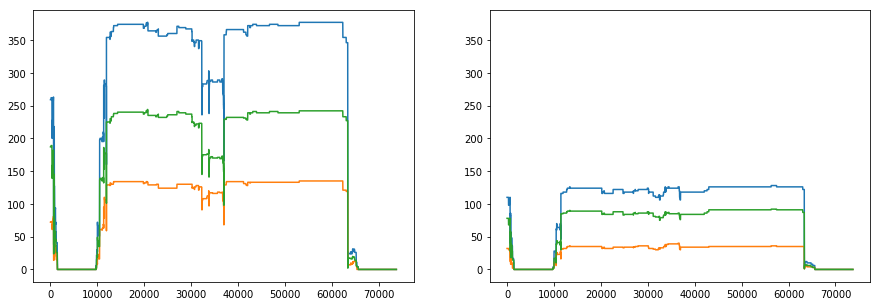

In [15]:
plt.figure(figsize=(15, 5))

ax =plt.subplot(1, 2, 1)
plt.plot(np.sum(ihart_contingency, axis=(1, 2)))
plt.plot(np.sum(ihart_contingency_f, axis=(1, 2)))
plt.plot(np.sum(ihart_contingency_m, axis=(1, 2)))

plt.subplot(1, 2, 2, sharey=ax)
plt.plot(np.sum(ssc_contingency, axis=(1, 2)))
plt.plot(np.sum(ssc_contingency_f, axis=(1, 2)))
plt.plot(np.sum(ssc_contingency_m, axis=(1, 2)))

plt.show()

In [16]:
import scipy.stats

def calc_hypergeometric_pvalue(ct):
    aut_trans, typ_trans, aut_notrans, typ_notrans = ct[1, 1], ct[0, 1], ct[1, 0], ct[0, 0]
    trans_op = typ_trans + aut_trans + aut_notrans + typ_notrans
    trans = typ_trans + aut_trans
    
    if aut_trans/(aut_trans+aut_notrans) > typ_trans/(typ_trans+typ_notrans):
        return 2*scipy.stats.hypergeom.sf(aut_trans, trans_op, aut_trans+aut_notrans, trans) + scipy.stats.hypergeom.pmf(aut_trans, trans_op, aut_trans+aut_notrans, trans)
    else:
        return 2*scipy.stats.hypergeom.cdf(aut_trans, trans_op, aut_trans+aut_notrans, trans)

cached_pvalue = dict()
ihart_pvalues = np.zeros((ihart_contingency.shape[0],))
ihart_pvalues_f = np.zeros((ihart_contingency.shape[0],))
ihart_pvalues_m = np.zeros((ihart_contingency.shape[0],))
ssc_pvalues = np.zeros((ssc_contingency.shape[0],))
ssc_pvalues_f = np.zeros((ssc_contingency.shape[0],))
ssc_pvalues_m = np.zeros((ssc_contingency.shape[0],))

for i in range(ihart_contingency.shape[0]):
    ct = ihart_contingency[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ihart_pvalues[i] = cached_pvalue[k]
    
    ct = ihart_contingency_f[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ihart_pvalues_f[i] = cached_pvalue[k]
    
    ct = ihart_contingency_m[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ihart_pvalues_m[i] = cached_pvalue[k]
    
    ct = ssc_contingency[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ssc_pvalues[i] = cached_pvalue[k]
    
    ct = ssc_contingency_f[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ssc_pvalues_f[i] = cached_pvalue[k]
    
    ct = ssc_contingency_m[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ssc_pvalues_m[i] = cached_pvalue[k]
        

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


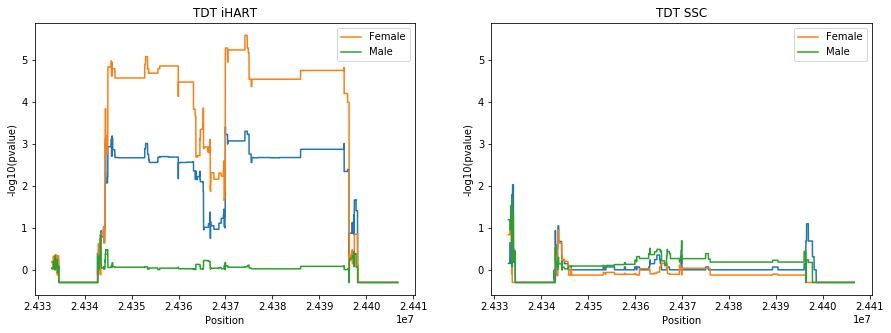

In [20]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.title('TDT iHART')
plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ihart_pvalues))
plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ihart_pvalues_f), label='Female')
plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ihart_pvalues_m), label='Male')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.legend()

plt.subplot(1, 2, 2, sharey=ax)
plt.title('TDT SSC')
plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ssc_pvalues))
plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ssc_pvalues_f), label='Female')
plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ssc_pvalues_m), label='Male')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.legend()
plt.show()

In [18]:
# cf. 
# [1] R. G. Newcombe. Two-sided confidence intervals for the single proportion, 1998
# [2] R. G. Newcombe. Interval Estimation for the difference between independent proportions:        comparison of eleven methods, 1998

import numpy as np
from statsmodels.stats.proportion import proportion_confint

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
def propci_wilson_cc(count, nobs, alpha=0.05):
    # get confidence limits for proportion
    # using wilson score method w/ cont correction
    # i.e. Method 4 in Newcombe [1]; 
    # verified via Table 1
    from scipy import stats
    n = nobs
    p = count/n
    q = 1.-p
    z = stats.norm.isf(alpha / 2.)
    z2 = z**2   
    denom = 2*(n+z2)
    num = 2.*n*p+z2-1.-z*np.sqrt(z2-2-1./n+4*p*(n*q+1))    
    ci_l = num/denom
    num = 2.*n*p+z2+1.+z*np.sqrt(z2+2-1./n+4*p*(n*q-1))
    ci_u = num/denom
    if p == 0:
        ci_l = 0.
    elif p == 1:
        ci_u = 1.
    return ci_l, ci_u

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


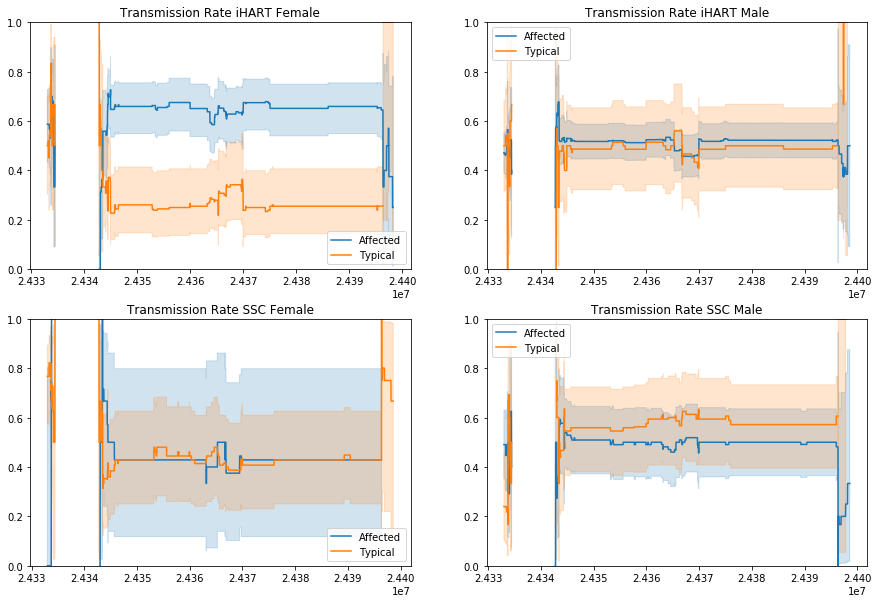

In [19]:
plt.figure(figsize=(15, 10))

def plot_with_error(contingency, label):
    f = contingency[:, 1]/np.sum(contingency, axis=1)
    e = [propci_wilson_cc(x, n) for x, n in zip(contingency[:, 1], np.sum(contingency, axis=1))]
    p = plt.plot(xs, f, label=label)
    plt.fill_between(xs, [x[0] for x in e], [x[1] for x in e], color=p[0].get_color(), alpha=0.2)


xs = range(inter_start_pos, inter_end_pos+1)

plt.subplot(2, 2, 1)
plot_with_error(ihart_contingency_f[:, 1, :], label='Affected')
plot_with_error(ihart_contingency_f[:, 0, :], label='Typical')
plt.title('Transmission Rate iHART Female')
plt.ylim([0, 1])
plt.legend()

plt.subplot(2, 2, 2)
plot_with_error(ihart_contingency_m[:, 1, :], label='Affected')
plot_with_error(ihart_contingency_m[:, 0, :], label='Typical')
plt.title('Transmission Rate iHART Male')
plt.ylim([0, 1])
plt.legend()

plt.subplot(2, 2, 3)
plot_with_error(ssc_contingency_f[:, 1, :], label='Affected')
plot_with_error(ssc_contingency_f[:, 0, :], label='Typical')
plt.title('Transmission Rate SSC Female')
plt.ylim([0, 1])
plt.legend()

plt.subplot(2, 2, 4)
plot_with_error(ssc_contingency_m[:, 1, :], label='Affected')
plot_with_error(ssc_contingency_m[:, 0, :], label='Typical')
plt.title('Transmission Rate SSC Male')
plt.ylim([0, 1])
plt.legend()

plt.show()

# Pull genotype data

In [262]:
import numpy as np
from scipy import sparse
from os import listdir

data_dir = '../split_gen_ihart'
chrom = '22'

# pull sample ids
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# pull coordinates
# coordinates[:, 1] is the position
# coordinates[:, 2] is 1 if the variant is a biallelic SNP else 0
coordinates = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom))
snp_positions = coordinates[:, 1]
snp_indices = coordinates[:, 2]==1

# pull genotype data from .npz
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])

# only keep the biallelic SNPS
whole_chrom = whole_chrom[:, snp_indices]
snp_positions = snp_positions[snp_indices]

m, n = whole_chrom.shape
print('chrom %s shape' % chrom, m, n)

chrom shape 4610 1004649


In [263]:
indices = np.where((snp_positions >= inter_start_pos) & (snp_positions <= inter_end_pos))[0]
gen = whole_chrom[:, indices].A
gen_pos = snp_positions[indices]

full_gen = np.zeros((gen.shape[0], inter_end_pos-inter_start_pos+1), dtype=np.int8)
full_gen[:, gen_pos-inter_start_pos] = gen

ihart_deletions_partial = ihart_deletions[:, gen_pos-inter_start_pos]

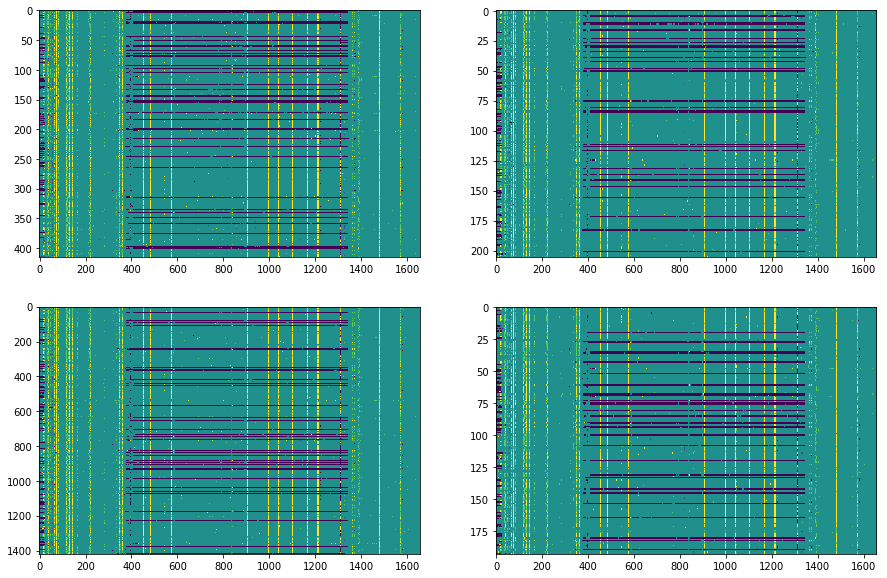

In [264]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
fem_aff_indices = np.where([x in ihart_ind_to_index and ihart_is_child[ihart_ind_to_index[x]] and child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2' for x in sample_ids])[0]
plt.imshow(gen[fem_aff_indices, :], aspect='auto')

plt.subplot(2, 2, 2)
fem_unaff_indices = np.where([x in ihart_ind_to_index and ihart_is_child[ihart_ind_to_index[x]] and child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1' for x in sample_ids])[0]
plt.imshow(gen[fem_unaff_indices, :], aspect='auto')

plt.subplot(2, 2, 3)
male_aff_indices = np.where([x in ihart_ind_to_index and ihart_is_child[ihart_ind_to_index[x]] and child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2' for x in sample_ids])[0]
plt.imshow(gen[male_aff_indices, :], aspect='auto')

plt.subplot(2, 2, 4)
male_unaff_indices = np.where([x in ihart_ind_to_index and ihart_is_child[ihart_ind_to_index[x]] and child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1' for x in sample_ids])[0]
plt.imshow(gen[male_unaff_indices, :], aspect='auto')

plt.show()

In [265]:
del_inds = [ihart_individuals[x] for x in np.where(np.any((ihart_deletions == 1) | (ihart_deletions == 4), axis=1))[0]]


In [302]:
import random

sample_id = random.choice(del_inds)
famkey, inds = [(k, v) for k, v in ihart_family_to_individuals.items() if sample_id in v][0]
print(famkey, inds)
print([child_id_to_sex[x] for x in inds])

AU1352.AU1352202.AU1352201 ['AU1352202', 'AU1352201', 'AU1352302', 'AU1352301']
['2', '1', '1', '1']


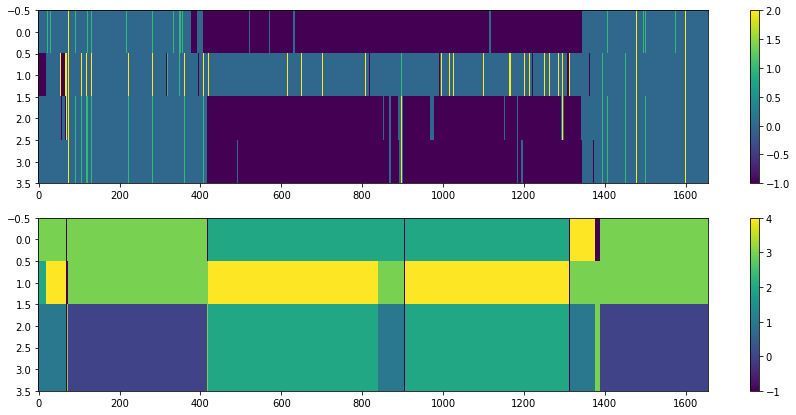

In [303]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.imshow(gen[[sample_id_to_index[x] for x in inds], :], aspect='auto', vmin=-1, vmax=2)
plt.colorbar()

plt.subplot(2, 1, 2)
plt.imshow(ihart_deletions_partial[[ihart_ind_to_index[x] for x in inds], :], aspect='auto', vmin=-1, vmax=4)
plt.colorbar()

plt.show()

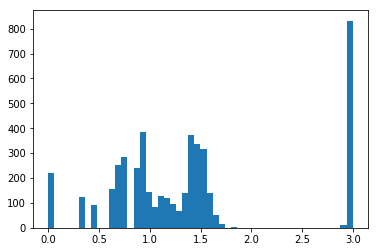

In [268]:
plt.hist(np.log10(np.sum(gen<0, axis=1)+1), bins=50)
plt.show()

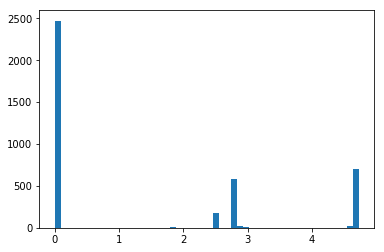

In [269]:
plt.hist(np.log10(np.sum(ihart_deletions==2, axis=1)+1), bins=50)
plt.show()

In [270]:
has_double = np.where(np.sum(gen<0, axis=1)>100)[0]
gen_has_double = set([sample_ids[i] for i in has_double])
has_double = np.where(np.sum(ihart_deletions==2, axis=1)>1000)[0]
del_has_double = set([ihart_individuals[i] for i in has_double])
print(len(gen_has_double), len(del_has_double))

print('Gen is dd, del is not', len((gen_has_double - del_has_double) & set(ihart_individuals)))
print('Gen is dd, del is not, moms', len((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_mother[i]])))
print('Gen is dd, del is not, dads', len((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_father[i]])))
print('Gen is dd, del is not, children', len((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_child[i]])))

print('Del is dd, gen is not', len(del_has_double - gen_has_double))

845 725
Gen is dd, del is not 4
Gen is dd, del is not, moms 1
Gen is dd, del is not, dads 2
Gen is dd, del is not, children 1
Del is dd, gen is not 1


In [271]:
print('Moms', sorted((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_mother[i]])))
print('Dads', sorted((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_father[i]])))
print('Children', sorted((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_child[i]])))



Moms ['AU0897202']
Dads ['AU045302', 'AU0923201']
Children ['AU1195303']


In [272]:
has_double = np.sum(gen<0, axis=1)>100
c = np.zeros((2, 2), dtype=int)
c[0, 0] = np.sum([x in child_id_to_affected and child_id_to_affected[x] == '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[0, 1] = np.sum([x in child_id_to_affected and child_id_to_affected[x] != '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[1, 0] = np.sum([x in child_id_to_affected and child_id_to_affected[x] == '2' and not has_double[i] for i, x in enumerate(sample_ids)])
c[1, 1] = np.sum([x in child_id_to_affected and child_id_to_affected[x] != '2' and not has_double[i] for i, x in enumerate(sample_ids)])
print(c, scipy.stats.chi2_contingency(c)[1])

c = np.zeros((2, 2), dtype=int)
c[0, 0] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[0, 1] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '2' and child_id_to_affected[x] != '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[1, 0] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2' and not has_double[i] for i, x in enumerate(sample_ids)])
c[1, 1] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '2' and child_id_to_affected[x] != '2' and not has_double[i] for i, x in enumerate(sample_ids)])
print(c, scipy.stats.chi2_contingency(c)[1])

c = np.zeros((2, 2), dtype=int)
c[0, 0] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[0, 1] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '1' and child_id_to_affected[x] != '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[1, 0] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2' and not has_double[i] for i, x in enumerate(sample_ids)])
c[1, 1] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '1' and child_id_to_affected[x] != '2' and not has_double[i] for i, x in enumerate(sample_ids)])
print(c, scipy.stats.chi2_contingency(c)[1])



[[ 418  427]
 [1764 1987]] 0.213115320824
[[ 102  218]
 [ 399 1054]] 0.128712488688
[[ 316  209]
 [1365  933]] 0.776492456897


# Look at maternal tobacco exposure

In [273]:
child_to_mte = dict()
with open('/Users/kelley/Projects/PhenotypeGLRM/Phenotype/AGRE_2015/Medical History Affected Child/AffChild1.csv', 'r') as f:
    header = next(f).strip().split(',')
    tobacco_index = header.index('Maternal_exposure_to_tobacco')
    sample_index = header.index('Individual ID')
    
    for line in f:
        pieces = line.strip().split(',')
        child_to_mte[pieces[sample_index]] = pieces[tobacco_index]
        
print(len(child_to_mte))

with open('/Users/kelley/Projects/PhenotypeGLRM/Phenotype/AGRE_2010/Medical History Affected Child/AffChild/AffChild1.csv', 'r') as f:
    header = next(f).strip().split(',')
    tobacco_index = header.index('Maternal_exposure_to_tobacco')
    sample_index = header.index('Individual ID')
    
    for line in f:
        pieces = line.strip().split(',')
        child_to_mte[pieces[sample_index]] = pieces[tobacco_index]

print(len(child_to_mte))
        
        

731
735


In [274]:
from collections import Counter

family_to_smoking_status = []
for fam, inds in ihart_family_to_individuals.items():
    y = [child_to_mte[x] for x in inds[2:] if x in child_to_mte]
    if len(y) > 1:
        family_to_smoking_status.append(tuple(y))
print(Counter(family_to_smoking_status))

Counter({('0', '0'): 127, ('0', '0', '0'): 12, ('-1', '-1'): 11, ('-1', '0'): 5, ('1', '1'): 4, (' ', '0'): 3, ('1', '0'): 2, ('0', ' '): 2, ('0', '0', '-1'): 2, ('0', '-1'): 2, (' ', ' '): 1, ('1', '-1', '1'): 1, ('0', '1', '0'): 1, ('0', '1'): 1, ('0', '-1', '-1'): 1})


In [275]:
mte_children = [k for k, v in child_to_mte.items() if v=='1']

not_mte_children = [k for k, v in child_to_mte.items() if v=='0']
unknown_mte_children = [k for k, v in child_to_mte.items() if v=='-1']
print('MTE children', len(mte_children))

mte_families = [k for k, inds in ihart_family_to_individuals.items() if np.any([x in child_to_mte and child_to_mte[x]=='-1' for x in inds[2:]])]
print('Families', len(mte_families))



MTE children 34
Families 25


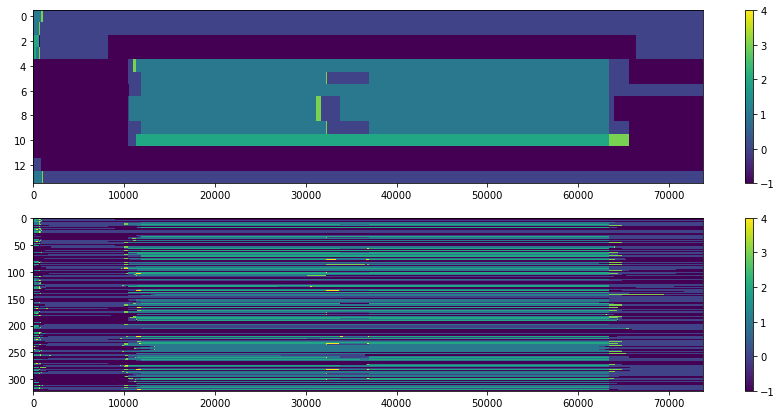

In [276]:
plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.imshow(ihart_deletions[[ihart_ind_to_index[x] for x in mte_children if x in ihart_ind_to_index], :], aspect='auto', vmin=-1, vmax=4)
plt.colorbar()

plt.subplot(2, 1, 2)
plt.imshow(ihart_deletions[[ihart_ind_to_index[x] for x in not_mte_children if x in ihart_ind_to_index], :], aspect='auto', vmin=-1, vmax=4)
plt.colorbar()

plt.show()

In [277]:
# SDT

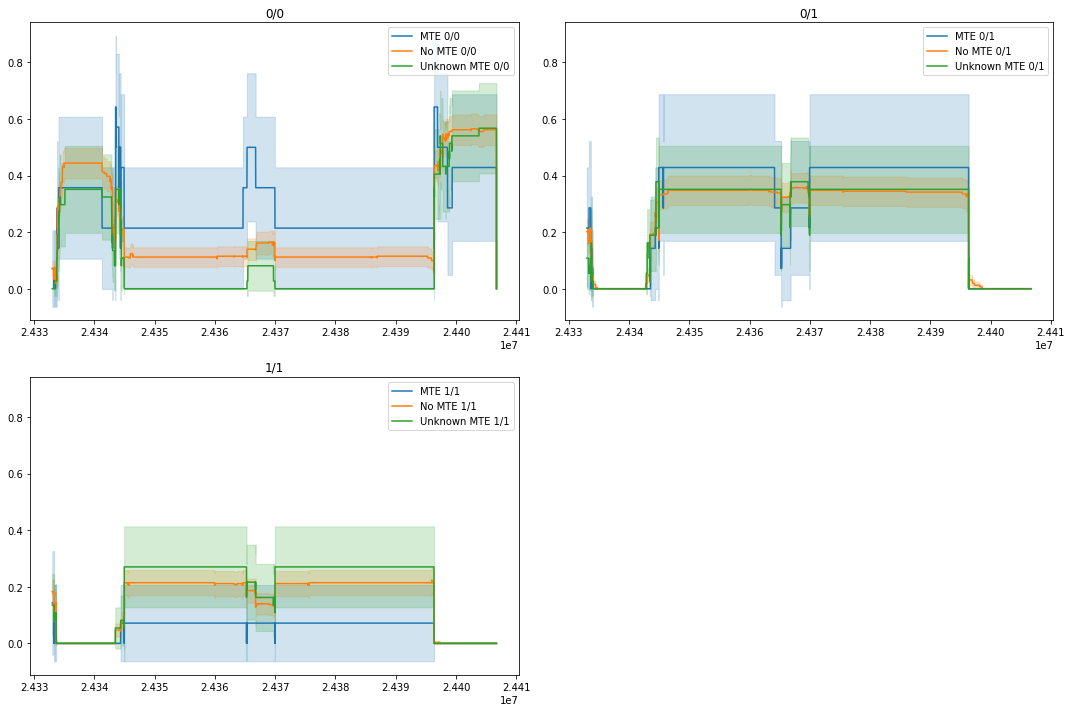

In [278]:

def plot_with_error(gen, children, label):
    f = np.sum(ihart_deletions[[ihart_ind_to_index[x] for x in children if x in ihart_ind_to_index], :]==gen, axis=0)/len([x for x in children if x in ihart_ind_to_index])
    e = [1.96*np.sqrt(x*(1-x)/len([x for x in children if x in ihart_ind_to_index])) for x in f]
    p = plt.plot(xs, f, label=label)
    plt.fill_between(xs, [x-y for x, y in zip(f, e)], [x+y for x, y in zip(f, e)], color=p[0].get_color(), alpha=0.2)

plt.figure(figsize=(15, 10))

ax = plt.subplot(2, 2, 1)
plt.title('0/0')
plot_with_error(0, mte_children, 'MTE 0/0')
plot_with_error(0, not_mte_children, 'No MTE 0/0')
plot_with_error(0, unknown_mte_children, 'Unknown MTE 0/0')
#plot_with_error(3, mte_children, 'MTE 0/0 or 0/1')
#plot_with_error(3, not_mte_children, 'No MTE 0/0 or 0/1')
plt.legend()

ax = plt.subplot(2, 2, 2, sharey=ax)
plt.title('0/1')
plot_with_error(1, mte_children, 'MTE 0/1')
plot_with_error(1, not_mte_children, 'No MTE 0/1')
plot_with_error(1, unknown_mte_children, 'Unknown MTE 0/1')
#plot_with_error(4, mte_children, 'MTE 0/1 or 1/1')
#plot_with_error(4, not_mte_children, 'No MTE 0/1 or 1/1')
plt.legend()

ax = plt.subplot(2, 2, 3, sharey=ax)
plt.title('1/1')
plot_with_error(2, mte_children, 'MTE 1/1')
plot_with_error(2, not_mte_children, 'No MTE 1/1')
plot_with_error(2, unknown_mte_children, 'Unknown MTE 1/1')

plt.legend()

plt.tight_layout()
plt.show()


In [279]:
mte_siblings = sum([inds[2:] for k, inds in ihart_family_to_individuals.items() if len(set(inds) & set(mte_children))>0], [])
print(len([x for x in mte_children if x in ihart_ind_to_index]))
print(len(mte_siblings))



14
23


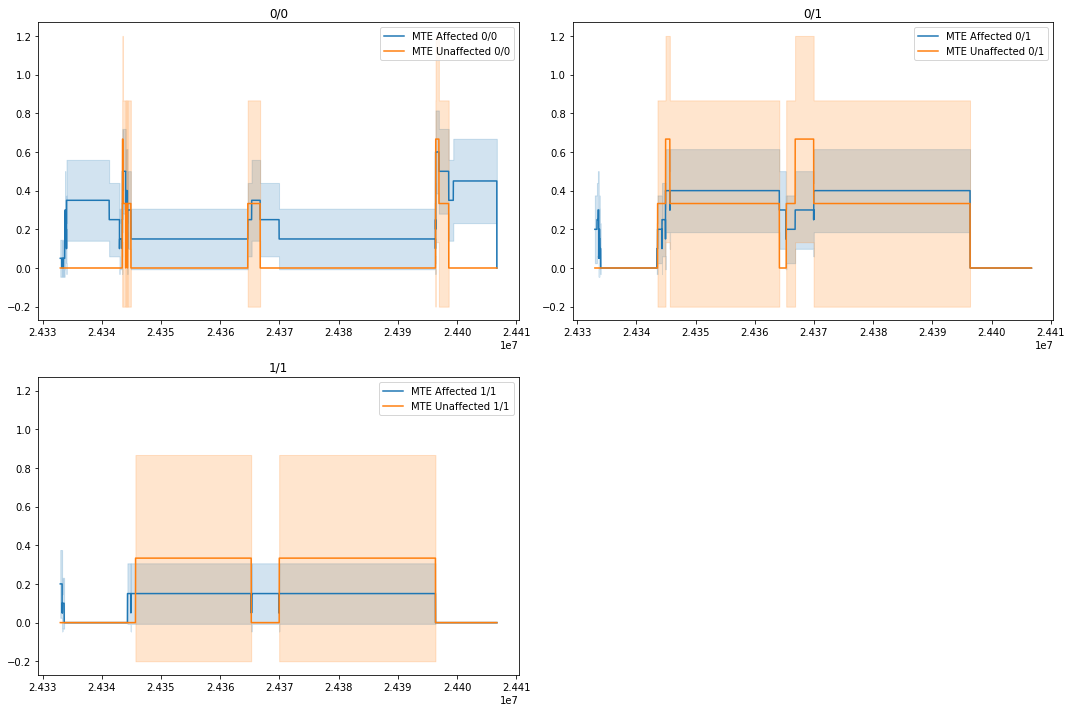

In [280]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(2, 2, 1)
plt.title('0/0')
plot_with_error(0, [x for x in mte_siblings if child_id_to_affected[x]=='2'], 'MTE Affected 0/0')
plot_with_error(0, [x for x in mte_siblings if child_id_to_affected[x]=='1'], 'MTE Unaffected 0/0')
plt.legend()

ax = plt.subplot(2, 2, 2, sharey=ax)
plt.title('0/1')
plot_with_error(1, [x for x in mte_siblings if child_id_to_affected[x]=='2'], 'MTE Affected 0/1')
plot_with_error(1, [x for x in mte_siblings if child_id_to_affected[x]=='1'], 'MTE Unaffected 0/1')
plt.legend()

ax = plt.subplot(2, 2, 3, sharey=ax)
plt.title('1/1')
plot_with_error(2, [x for x in mte_siblings if child_id_to_affected[x]=='2'], 'MTE Affected 1/1')
plot_with_error(2, [x for x in mte_siblings if child_id_to_affected[x]=='1'], 'MTE Unaffected 1/1')

plt.legend()

plt.tight_layout()
plt.show()
